# Лабораторная работа 6, Лохматов Никита Игоревич М8О-406Б-21

## 1. Выбор начальных условий

### a. Набор данных для классификации: Intel Image Classification

Датасет Intel Image Classification (https://www.kaggle.com/datasets/puneet6060/intel-image-classification) содержит изображения различных типов природных и городских ландшафтов: горы, леса, улицы, здания, ледники и морские пейзажи. Данная задача классификации направлена на автоматическое определение типа ландшафта по изображению. Это имеет высокую практическую значимость, так как может применяться:

- в геоинформационных системах (GIS),
- при анализе спутниковых снимков,
- в системах беспилотного вождения для ориентации в пространстве,
- в системах мониторинга окружающей среды и урбанизации.

Набор данных хорошо сбалансирован, содержит шесть четко определённых классов и подходит как для базового обучения моделей, так и для расширенных экспериментов с аугментациями, трансформерами и кастомными архитектурами. Благодаря небольшому размеру, он удобен для быстрого прототипирования и визуализации результатов.



### b. Выбор метрик качества и обоснование

Для задачи многоклассовой классификации ландшафтов используются следующие метрики:

1. Accuracy – общая точность.

- Показывает, сколько предсказаний модель сделала правильно.

- Обоснование: является базовой метрикой, даёт общее понимание, насколько хорошо модель справляется с классификацией при наличии нескольких классов. Однако при дисбалансе классов может вводить в заблуждение.

2. Precision – доля объектов, отнесённых моделью к определённому классу, которые действительно к нему принадлежат.

- Обоснование: важно для минимизации ложных положительных результатов, особенно в задачах, где критично не перепутать классы, например, спутниковое распознавание городской застройки и природных территорий.

3. Recall – доля объектов определённого класса, которые модель правильно распознала.

- Обоснование: важно при необходимости максимально охватить все случаи конкретного класса, например, при автоматическом мониторинге природных зон.

4. F1-score – гармоническое среднее между Precision и Recall.

- Обоснование: помогает сбалансировать точность и полноту, особенно полезен в случае, когда классы представлены неравномерно.

5. Weighted average – усреднение с учётом количества объектов в каждом классе.

- Обоснование: учитывает дисбаланс классов, отражая реальное поведение модели на всём датасете.

## 2. Создание бейзлайна и оценка качества

In [20]:
dataset_train = '../datasets/seg_train'
dataset_test = '../datasets/seg_test'

### a. Обучение моделей из torchvision

Импортируем библиотеки

In [21]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights, vit_b_16, ViT_B_16_Weights
from sklearn.metrics import classification_report
import seaborn as sns
from copy import deepcopy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Сделаем предобработку данных

In [22]:
# Количество картинок (None = брать все)
NUM_TRAIN_SAMPLES = 100
NUM_TEST_SAMPLES = 100
SIZE = 224

# Трансформации для данных
train_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

test_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

# Загрузка датасетов
full_train_dataset = datasets.ImageFolder(root=dataset_train, transform=train_transforms)
full_test_dataset = datasets.ImageFolder(root=dataset_test, transform=test_transforms)

# Получение случайных подвыборок
def get_subset(dataset, num_samples):
    if num_samples is None or num_samples >= len(dataset):
        return dataset
    indices = random.sample(range(len(dataset)), num_samples)
    
    return Subset(dataset, indices)

# Применяем ограничение на количество изображений
train_dataset = get_subset(full_train_dataset, NUM_TRAIN_SAMPLES)
test_dataset = get_subset(full_test_dataset, NUM_TEST_SAMPLES)

# Создание DataLoader'ов
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Получение названий классов (для отчётов и матрицы ошибок)
class_names = full_train_dataset.classes
print("Классы:", class_names)

Классы: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Обучение модели (общая логика)


In [ ]:
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=3, is_print=True):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        if is_print:
            print(f"Эпоха {epoch+1}/{num_epochs}, Потери: {epoch_loss:.4f}")

    # Просто проверка, что модель работает на тестовых данных
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total

    if is_print:
        print(f"Точность на тестовой выборке: {acc:.2f}")

Свёрточная модель: ResNet18 

In [24]:
# Загружаем предобученную модель и адаптируем под число классов
weights = ResNet18_Weights.DEFAULT
resnet18 = resnet18(weights=weights)
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(class_names))

# Настройка оптимизатора и функции потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=1e-4)

# Обучение
train_model(resnet18, criterion, optimizer, train_loader, test_loader)

Эпоха 1/3, Потери: 1.7664
Эпоха 2/3, Потери: 0.5600
Эпоха 3/3, Потери: 0.2351
Точность на тестовой выборке: 0.69


Трансформерная модель: ViT

In [25]:
# Импорт модели ViT из torchvision
weights = ViT_B_16_Weights.DEFAULT
vit = vit_b_16(weights=weights)
vit.heads.head = nn.Linear(vit.heads.head.in_features, len(class_names))

# Настройка оптимизатора и функции потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=1e-4)

# Обучение
train_model(vit, criterion, optimizer, train_loader, test_loader)

Эпоха 1/3, Потери: 1.4613
Эпоха 2/3, Потери: 0.3930
Эпоха 3/3, Потери: 0.2069
Точность на тестовой выборке: 0.79


### b. Оценка качества моделей по выбранным метрикам на выбранном наборе данных

Расчёт метрик

In [26]:

def evaluate_model(model, dataloader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    label_ids = list(range(len(class_names)))
    report = classification_report(
        y_true,
        y_pred,
        labels=label_ids,
        target_names=class_names,
        zero_division=0,
        output_dict=True
    )
    
    return report


ResNet18

In [27]:
report_resnet = evaluate_model(resnet18, test_loader, class_names)

# Извлекаем нужные метрики
accuracy_resnet = report_resnet["accuracy"]
precision_resnet = report_resnet["macro avg"]["precision"]
recall_resnet = report_resnet["macro avg"]["recall"]
f1_resnet = report_resnet["macro avg"]["f1-score"]
weighted_resnet = report_resnet["weighted avg"]["f1-score"]

print(f"ResNet18 Accuracy: {accuracy_resnet:.4f}")
print(f"Precision: {precision_resnet:.4f}, Recall: {recall_resnet:.4f}, F1: {f1_resnet:.4f}")
print(f"Weighted avg: {weighted_resnet:.4f}")


ResNet18 Accuracy: 0.6900
Precision: 0.8151, Recall: 0.6925, F1: 0.6880
Weighted avg: 0.6783


ViT

In [28]:
report_vit = evaluate_model(vit, test_loader, class_names)

# Извлекаем нужные метрики
accuracy_vit = report_vit["accuracy"]
precision_vit = report_vit["macro avg"]["precision"]
recall_vit = report_vit["macro avg"]["recall"]
f1_vit = report_vit["macro avg"]["f1-score"]
weighted_vit = report_vit["weighted avg"]["f1-score"]

print(f"ViT Accuracy: {accuracy_vit:.4f}")
print(f"Precision: {precision_vit:.4f}, Recall: {recall_vit:.4f}, F1: {f1_vit:.4f}")
print(f"Weighted avg: {weighted_vit:.4f}")

ViT Accuracy: 0.7900
Precision: 0.8262, Recall: 0.8084, F1: 0.7928
Weighted avg: 0.7771


Сравнение ResNet и ViT


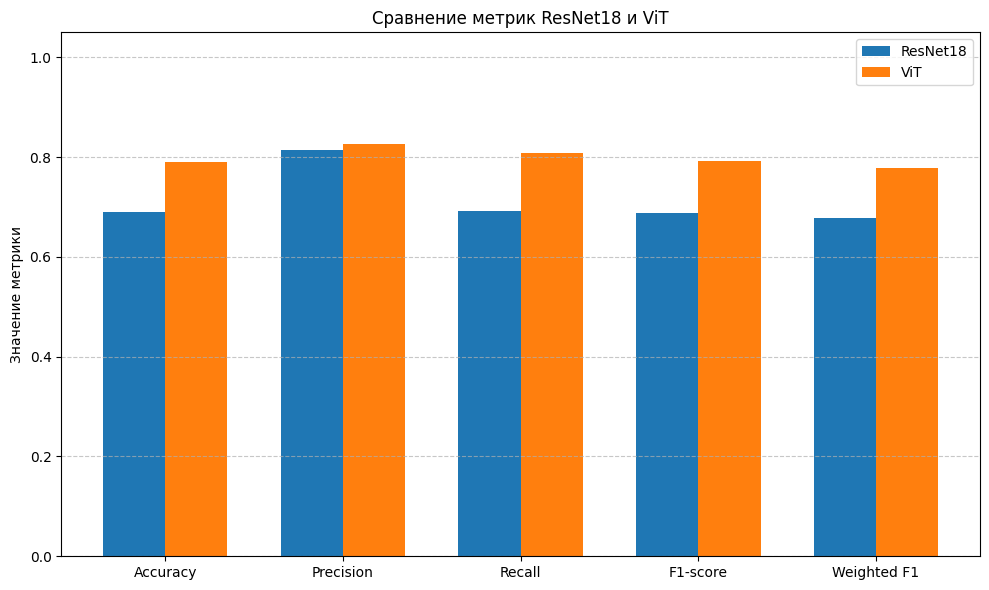

In [29]:
# Подготовка данных
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
resnet_scores = [accuracy_resnet, precision_resnet, recall_resnet, f1_resnet, weighted_resnet]
vit_scores = [accuracy_vit, precision_vit, recall_vit, f1_vit, weighted_vit]

x = np.arange(len(metrics))
width = 0.35

# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, resnet_scores, width, label="ResNet18")
plt.bar(x + width / 2, vit_scores, width, label="ViT")

plt.ylabel("Значение метрики")
plt.title("Сравнение метрик ResNet18 и ViT")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 3. Улучшение бейзлайна

### a. Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)


1. Улучшение аугментаций: если добавить более агрессивные и разнообразные аугментации (например, изменение яркости, контрастности, увеличение/уменьшение, переворот по вертикали), то модель будет устойчивее к различным условиям съёмки и переобучаться меньше

2. Настройка гиперпараметров — LR, батч, эпохи

3. Подбор другой архитектуры — MobileNetV3 или EfficientNet

### b. Проверка гипотез

1. Улучшение аугментаций

Эпоха 1/3, Потери: 1.4451
Эпоха 2/3, Потери: 0.7081
Эпоха 3/3, Потери: 0.4616
Точность на тестовой выборке: 0.77
Эпоха 1/3, Потери: 1.3375
Эпоха 2/3, Потери: 0.3937
Эпоха 3/3, Потери: 0.1531
Точность на тестовой выборке: 0.78
ResNet18 (аугмент.):
Accuracy: 0.7700
Precision: 0.7770, Recall: 0.7689, F1: 0.7647
Weighted avg: 0.7685
ViT (аугмент.):
Accuracy: 0.7800
Precision: 0.8041, Recall: 0.7832, F1: 0.7676
Weighted avg: 0.7728


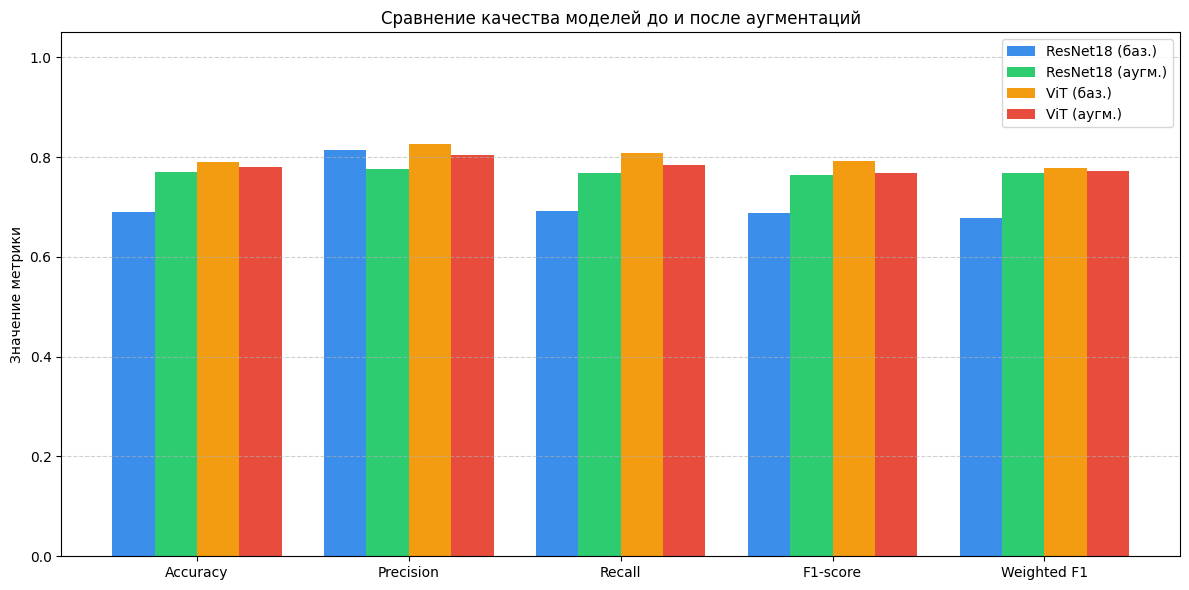

In [30]:
from torchvision.models import resnet18, ResNet18_Weights


# Аугментированный train-трансформ
augmented_train_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

# Тестовый трансформ
test_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

full_train_dataset = datasets.ImageFolder(root=dataset_train, transform=augmented_train_transforms)
full_test_dataset = datasets.ImageFolder(root=dataset_test, transform=test_transforms)

train_indices = random.sample(range(len(full_train_dataset)), NUM_TRAIN_SAMPLES)
test_indices = random.sample(range(len(full_test_dataset)), NUM_TEST_SAMPLES)

aug_train_dataset_small = Subset(full_train_dataset, train_indices)
test_dataset_small = Subset(full_test_dataset, test_indices)

aug_train_loader = DataLoader(aug_train_dataset_small, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset_small, batch_size=4, shuffle=False)

weights = ResNet18_Weights.DEFAULT
resnet_aug = resnet18(weights=weights)
resnet_aug.fc = nn.Linear(resnet_aug.fc.in_features, len(class_names))

resnet_aug = resnet_aug.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_aug.parameters(), lr=1e-4)

train_model(resnet_aug, criterion, optimizer, aug_train_loader, test_loader)

weights = ViT_B_16_Weights.DEFAULT
vit_aug = vit_b_16(weights=weights)
vit_aug.heads.head = nn.Linear(vit_aug.heads.head.in_features, len(class_names))

vit_aug = vit_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_aug.parameters(), lr=1e-4)

train_model(vit_aug, criterion, optimizer, aug_train_loader, test_loader)

report_resnet_aug = evaluate_model(resnet_aug, test_loader, class_names)

accuracy_resnet_aug = report_resnet_aug["accuracy"]
precision_resnet_aug = report_resnet_aug["macro avg"]["precision"]
recall_resnet_aug = report_resnet_aug["macro avg"]["recall"]
f1_resnet_aug = report_resnet_aug["macro avg"]["f1-score"]
weighted_resnet_aug = report_resnet_aug["weighted avg"]["f1-score"]

print("ResNet18 (аугмент.):")
print(f"Accuracy: {accuracy_resnet_aug:.4f}")
print(f"Precision: {precision_resnet_aug:.4f}, Recall: {recall_resnet_aug:.4f}, F1: {f1_resnet_aug:.4f}")
print(f"Weighted avg: {weighted_resnet_aug:.4f}")

report_vit_aug = evaluate_model(vit_aug, test_loader, class_names)

accuracy_vit_aug = report_vit_aug["accuracy"]
precision_vit_aug = report_vit_aug["macro avg"]["precision"]
recall_vit_aug = report_vit_aug["macro avg"]["recall"]
f1_vit_aug = report_vit_aug["macro avg"]["f1-score"]
weighted_vit_aug = report_vit_aug["weighted avg"]["f1-score"]

print("ViT (аугмент.):")
print(f"Accuracy: {accuracy_vit_aug:.4f}")
print(f"Precision: {precision_vit_aug:.4f}, Recall: {recall_vit_aug:.4f}, F1: {f1_vit_aug:.4f}")
print(f"Weighted avg: {weighted_vit_aug:.4f}")

# Метрики, которые будем сравнивать
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]

resnet_vals = [accuracy_resnet, precision_resnet, recall_resnet, f1_resnet, weighted_resnet]
resnet_aug_vals = [accuracy_resnet_aug, precision_resnet_aug, recall_resnet_aug, f1_resnet_aug, weighted_resnet_aug]

vit_vals = [accuracy_vit, precision_vit, recall_vit, f1_vit, weighted_vit]
vit_aug_vals = [accuracy_vit_aug, precision_vit_aug, recall_vit_aug, f1_vit_aug, weighted_vit_aug]

x = np.arange(len(metrics))
width = 0.2

# Построение графика
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * width, resnet_vals, width, label="ResNet18 (баз.)", color="#3b8eea")
plt.bar(x - 0.5 * width, resnet_aug_vals, width, label="ResNet18 (аугм.)", color="#2ecc71")
plt.bar(x + 0.5 * width, vit_vals, width, label="ViT (баз.)", color="#f39c12")
plt.bar(x + 1.5 * width, vit_aug_vals, width, label="ViT (аугм.)", color="#e74c3c")

# Подписи
plt.ylabel("Значение метрики")
plt.title("Сравнение качества моделей до и после аугментаций")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

2. Настройка гиперпараметров

ResNet18 | Тест: LR=0.001, Batch=4, Epochs=3
Точность на тестовой выборке: 0.42
ResNet18 | Тест: LR=0.001, Batch=4, Epochs=4
Точность на тестовой выборке: 0.52
ResNet18 | Тест: LR=0.001, Batch=8, Epochs=3
Точность на тестовой выборке: 0.28
ResNet18 | Тест: LR=0.001, Batch=8, Epochs=4
Точность на тестовой выборке: 0.57
ResNet18 | Тест: LR=0.0001, Batch=4, Epochs=3
Точность на тестовой выборке: 0.86
ResNet18 | Тест: LR=0.0001, Batch=4, Epochs=4
Точность на тестовой выборке: 0.87
ResNet18 | Тест: LR=0.0001, Batch=8, Epochs=3
Точность на тестовой выборке: 0.86
ResNet18 | Тест: LR=0.0001, Batch=8, Epochs=4
Точность на тестовой выборке: 0.85
ViT | Тест: LR=0.001, Batch=4, Epochs=3
Точность на тестовой выборке: 0.13
ViT | Тест: LR=0.001, Batch=4, Epochs=4
Точность на тестовой выборке: 0.33
ViT | Тест: LR=0.001, Batch=8, Epochs=3
Точность на тестовой выборке: 0.35
ViT | Тест: LR=0.001, Batch=8, Epochs=4
Точность на тестовой выборке: 0.28
ViT | Тест: LR=0.0001, Batch=4, Epochs=3
Точность на тес

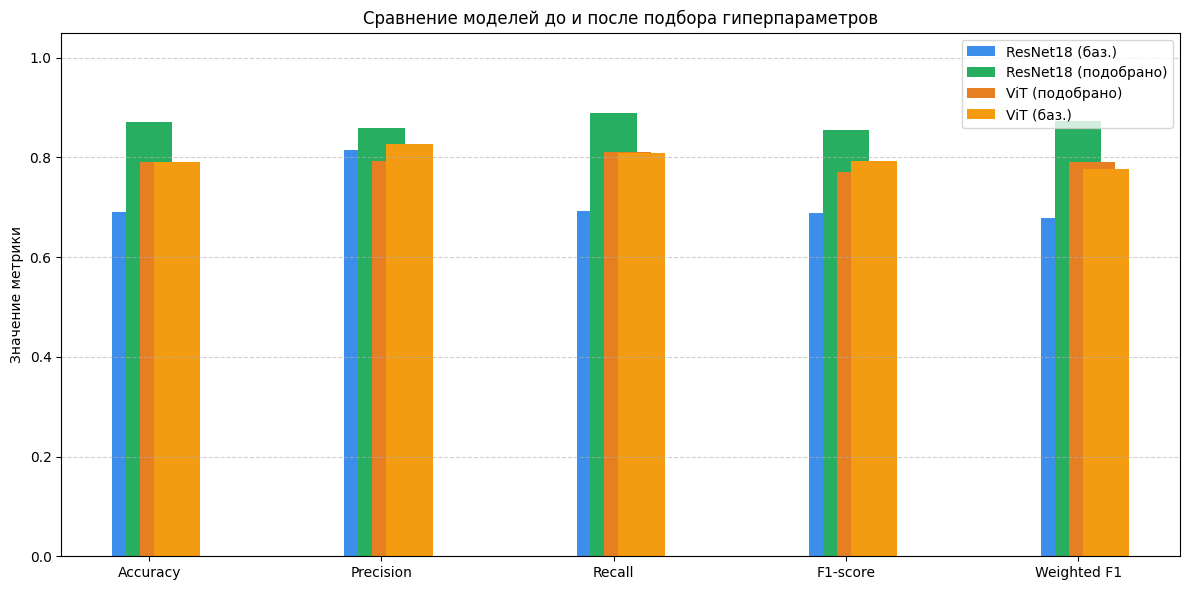

In [31]:
lr_options = [1e-3, 1e-4]
batch_options = [4, 8]
epoch_options = [3, 4]

simple_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

full_train_dataset = datasets.ImageFolder(root=dataset_train, transform=simple_transforms)
full_test_dataset = datasets.ImageFolder(root=dataset_test, transform=simple_transforms)

train_indices = random.sample(range(len(full_train_dataset)), NUM_TRAIN_SAMPLES)
test_indices = random.sample(range(len(full_test_dataset)), NUM_TEST_SAMPLES)

train_dataset_hp = Subset(full_train_dataset, train_indices)
test_dataset_hp = Subset(full_test_dataset, test_indices)
            
results_resnet = []
results_vit = []

for lr in lr_options:
    for batch in batch_options:
        for epochs in epoch_options:
            print(f"ResNet18 | Тест: LR={lr}, Batch={batch}, Epochs={epochs}")

            train_loader_hp = DataLoader(train_dataset_hp, batch_size=batch, shuffle=True, num_workers=0)
            test_loader_hp = DataLoader(test_dataset_hp, batch_size=batch, shuffle=False)

            model_r = resnet18(weights=ResNet18_Weights.DEFAULT)
            model_r.fc = nn.Linear(model_r.fc.in_features, len(class_names))
            model_r = model_r.to(device)

            optimizer_r = optim.Adam(model_r.parameters(), lr=lr)
            criterion_r = nn.CrossEntropyLoss()

            train_model(model_r, criterion_r, optimizer_r, train_loader_hp, test_loader_hp, num_epochs=epochs, is_print=False)
            report_r = evaluate_model(model_r, test_loader_hp, class_names)

            results_resnet.append({
                "lr": lr, "batch": batch, "epochs": epochs,
                "f1": report_r["macro avg"]["f1-score"],
                "acc": report_r["accuracy"],
                "report": deepcopy(report_r)
            })

for lr in lr_options:
    for batch in batch_options:
        for epochs in epoch_options:
            print(f"ViT | Тест: LR={lr}, Batch={batch}, Epochs={epochs}")

            train_loader_hp = DataLoader(train_dataset_hp, batch_size=batch, shuffle=True, num_workers=0)
            test_loader_hp = DataLoader(test_dataset_hp, batch_size=batch, shuffle=False)

            model_v = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
            model_v.heads.head = nn.Linear(model_v.heads.head.in_features, len(class_names))
            model_v = model_v.to(device)

            optimizer_v = optim.Adam(model_v.parameters(), lr=lr)
            criterion_v = nn.CrossEntropyLoss()

            train_model(model_v, criterion_v, optimizer_v, train_loader_hp, test_loader_hp, num_epochs=epochs, is_print=False)
            report_v = evaluate_model(model_v, test_loader_hp, class_names)

            results_vit.append({
                "lr": lr, "batch": batch, "epochs": epochs,
                "f1": report_v["macro avg"]["f1-score"],
                "acc": report_v["accuracy"],
                "report": deepcopy(report_v)
            })

best_resnet = max(results_resnet, key=lambda x: x["f1"])
best_vit = max(results_vit, key=lambda x: x["f1"])

print("\nЛучшие гиперпараметры: ResNet18")
print(f"LR: {best_resnet['lr']}, Batch: {best_resnet['batch']}, Epochs: {best_resnet['epochs']}, F1: {best_resnet['f1']:.4f}")

print("\nЛучшие гиперпараметры: ViT")
print(f"LR: {best_vit['lr']}, Batch: {best_vit['batch']}, Epochs: {best_vit['epochs']}, F1: {best_vit['f1']:.4f}")

# Графики
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
x = np.arange(len(metrics))
width = 0.2

resnet_best_vals = [
    best_resnet["report"]["accuracy"],
    best_resnet["report"]["macro avg"]["precision"],
    best_resnet["report"]["macro avg"]["recall"],
    best_resnet["report"]["macro avg"]["f1-score"],
    best_resnet["report"]["weighted avg"]["f1-score"]
]

vit_best_vals = [
    best_vit["report"]["accuracy"],
    best_vit["report"]["macro avg"]["precision"],
    best_vit["report"]["macro avg"]["recall"],
    best_vit["report"]["macro avg"]["f1-score"],
    best_vit["report"]["weighted avg"]["f1-score"]
]

plt.figure(figsize=(12, 6))
plt.bar(x - 0.3 * width, resnet_vals, width, label="ResNet18 (баз.)", color="#3b8eea")
plt.bar(x, resnet_best_vals, width, label="ResNet18 (подобрано)", color="#27ae60")
plt.bar(x + 0.3 * width, vit_best_vals, width, label="ViT (подобрано)", color="#e67e22")
plt.bar(x + 0.6 * width, vit_vals, width, label="ViT (баз.)", color="#f39c12")

plt.ylabel("Значение метрики")
plt.title("Сравнение моделей до и после подбора гиперпараметров")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

3. Подбор другой архитектуры

Эпоха 1/3, Потери: 1.7534
Эпоха 2/3, Потери: 1.3840
Эпоха 3/3, Потери: 1.0959
Точность на тестовой выборке: 0.59
Эпоха 1/3, Потери: 1.7793
Эпоха 2/3, Потери: 1.4714
Эпоха 3/3, Потери: 1.2115
Точность на тестовой выборке: 0.59


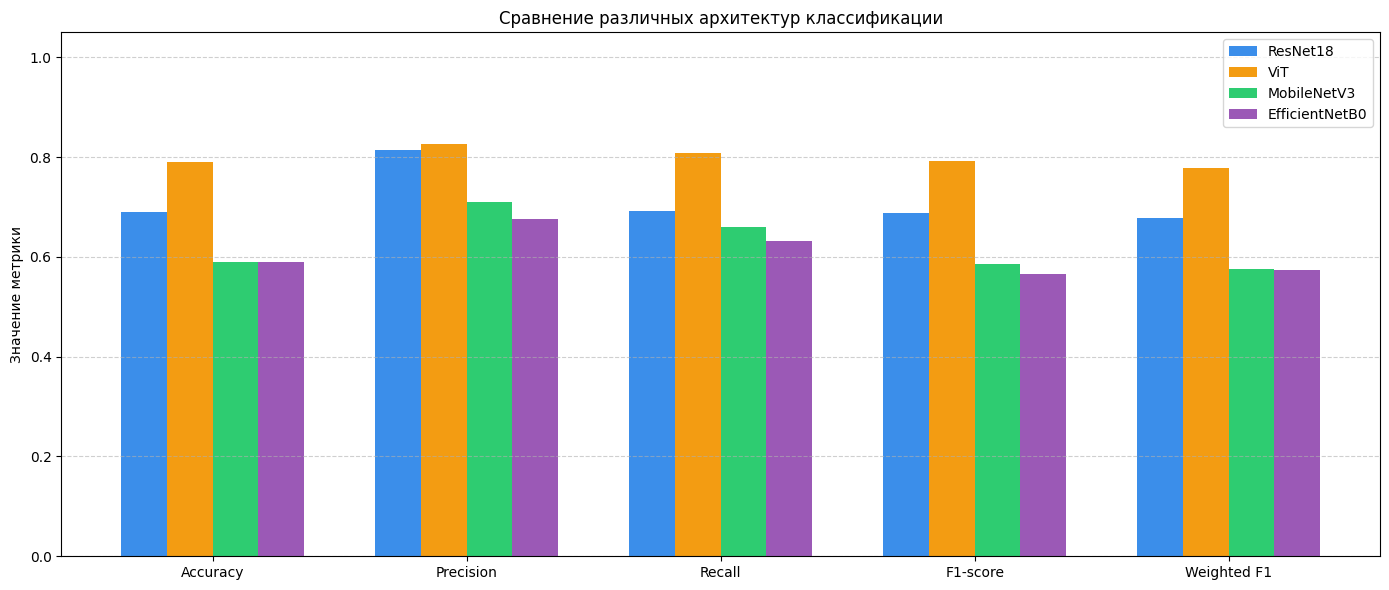

In [32]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights


# MobileNetV3
model_mobile = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
model_mobile.classifier[3] = nn.Linear(model_mobile.classifier[3].in_features, len(class_names))
model_mobile = model_mobile.to(device)

optimizer_mobile = optim.Adam(model_mobile.parameters(), lr=1e-4)
criterion_mobile = nn.CrossEntropyLoss()

train_model(model_mobile, criterion_mobile, optimizer_mobile, train_loader_hp, test_loader_hp, num_epochs=3)

report_mobile = evaluate_model(model_mobile, test_loader_hp, class_names)

# Извлекаем метрики
accuracy_mobile = report_mobile["accuracy"]
precision_mobile = report_mobile["macro avg"]["precision"]
recall_mobile = report_mobile["macro avg"]["recall"]
f1_mobile = report_mobile["macro avg"]["f1-score"]
weighted_mobile = report_mobile["weighted avg"]["f1-score"]

# EfficientNetB0
model_effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model_effnet.classifier[1] = nn.Linear(model_effnet.classifier[1].in_features, len(class_names))
model_effnet = model_effnet.to(device)

optimizer_eff = optim.Adam(model_effnet.parameters(), lr=1e-4)
criterion_eff = nn.CrossEntropyLoss()

train_model(model_effnet, criterion_eff, optimizer_eff, train_loader_hp, test_loader_hp, num_epochs=3)

report_eff = evaluate_model(model_effnet, test_loader_hp, class_names)

# Извлекаем метрики
accuracy_eff = report_eff["accuracy"]
precision_eff = report_eff["macro avg"]["precision"]
recall_eff = report_eff["macro avg"]["recall"]
f1_eff = report_eff["macro avg"]["f1-score"]
weighted_eff = report_eff["weighted avg"]["f1-score"]

metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
x = np.arange(len(metrics))
width = 0.18

mobilenet_vals = [accuracy_mobile, precision_mobile, recall_mobile, f1_mobile, weighted_mobile]
effnet_vals = [accuracy_eff, precision_eff, recall_eff, f1_eff, weighted_eff]

plt.figure(figsize=(14, 6))
plt.bar(x - 1.5 * width, resnet_vals, width, label="ResNet18", color="#3b8eea")
plt.bar(x - 0.5 * width, vit_vals, width, label="ViT", color="#f39c12")
plt.bar(x + 0.5 * width, mobilenet_vals, width, label="MobileNetV3", color="#2ecc71")
plt.bar(x + 1.5 * width, effnet_vals, width, label="EfficientNetB0", color="#9b59b6")

plt.ylabel("Значение метрики")
plt.title("Сравнение различных архитектур классификации")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### c. Формирование улучшенного бейзлайна

В улучшенном бейзлайне будем использовать всё те же ResNet и ViT, так как они показали себя гораздо лучше. Также добавим аугментации.

Лучшие гиперпараметры: ResNet18
LR: 0.0001, Batch: 4, Epochs: 4

Лучшие гиперпараметры: ViT
LR: 0.0001, Batch: 4, Epochs: 4

### d. Обучение модели с улучшенным бейзлайном 

In [33]:
train_best_transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

resnet_train_full = datasets.ImageFolder(root=dataset_train, transform=train_best_transform)
vit_train_full = datasets.ImageFolder(root=dataset_train, transform=train_best_transform)
test_full = datasets.ImageFolder(root=dataset_test, transform=train_best_transform)

resnet_train = Subset(resnet_train_full, random.sample(range(len(resnet_train_full)), NUM_TRAIN_SAMPLES))
vit_train = Subset(vit_train_full, random.sample(range(len(vit_train_full)), NUM_TRAIN_SAMPLES))
test_set = Subset(test_full, random.sample(range(len(test_full)), NUM_TEST_SAMPLES))

resnet_best_train_loader = DataLoader(resnet_train, batch_size=4, shuffle=True)
vit_best_train_loader = DataLoader(vit_train, batch_size=4, shuffle=True)
test_best_loader = DataLoader(test_set, batch_size=4, shuffle=False)

class_names = resnet_train_full.classes

ResNet

In [34]:
weights = ResNet18_Weights.DEFAULT
resnet_model = resnet18(weights=weights)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(class_names))
resnet_model = resnet_model.to(device)

optimizer_res = optim.Adam(resnet_model.parameters(), lr=1e-4)
criterion_res = nn.CrossEntropyLoss()

train_model(resnet_model, criterion_res, optimizer_res, resnet_best_train_loader, test_best_loader, num_epochs=4)
report_best_resnet = evaluate_model(resnet_model, test_loader, class_names)

# Метрики
accuracy_best_resnet = report_best_resnet["accuracy"]
precision_best_resnet = report_best_resnet["macro avg"]["precision"]
recall_best_resnet = report_best_resnet["macro avg"]["recall"]
f1_best_resnet = report_best_resnet["macro avg"]["f1-score"]
weighted_best_resnet = report_best_resnet["weighted avg"]["f1-score"]

Эпоха 1/4, Потери: 1.4001
Эпоха 2/4, Потери: 0.6600
Эпоха 3/4, Потери: 0.3435
Эпоха 4/4, Потери: 0.4598
Точность на тестовой выборке: 0.86


ViT

In [35]:
vit_model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, len(class_names))
vit_model = vit_model.to(device)

optimizer_vit = optim.Adam(vit_model.parameters(), lr=1e-4)
criterion_vit = nn.CrossEntropyLoss()

train_model(vit_model, criterion_vit, optimizer_vit, vit_best_train_loader, test_best_loader, num_epochs=4)
report_best_vit = evaluate_model(vit_model, test_loader, class_names)

# Метрики
accuracy_best_vit = report_best_vit["accuracy"]
precision_best_vit = report_best_vit["macro avg"]["precision"]
recall_best_vit = report_best_vit["macro avg"]["recall"]
f1_best_vit = report_best_vit["macro avg"]["f1-score"]
weighted_best_vit = report_best_vit["weighted avg"]["f1-score"]

Эпоха 1/4, Потери: 1.0933
Эпоха 2/4, Потери: 0.3874
Эпоха 3/4, Потери: 0.1736
Эпоха 4/4, Потери: 0.1307
Точность на тестовой выборке: 0.78


### f. Сравнение результатов первоначального бейзлайна с улучшенным бейзлайном

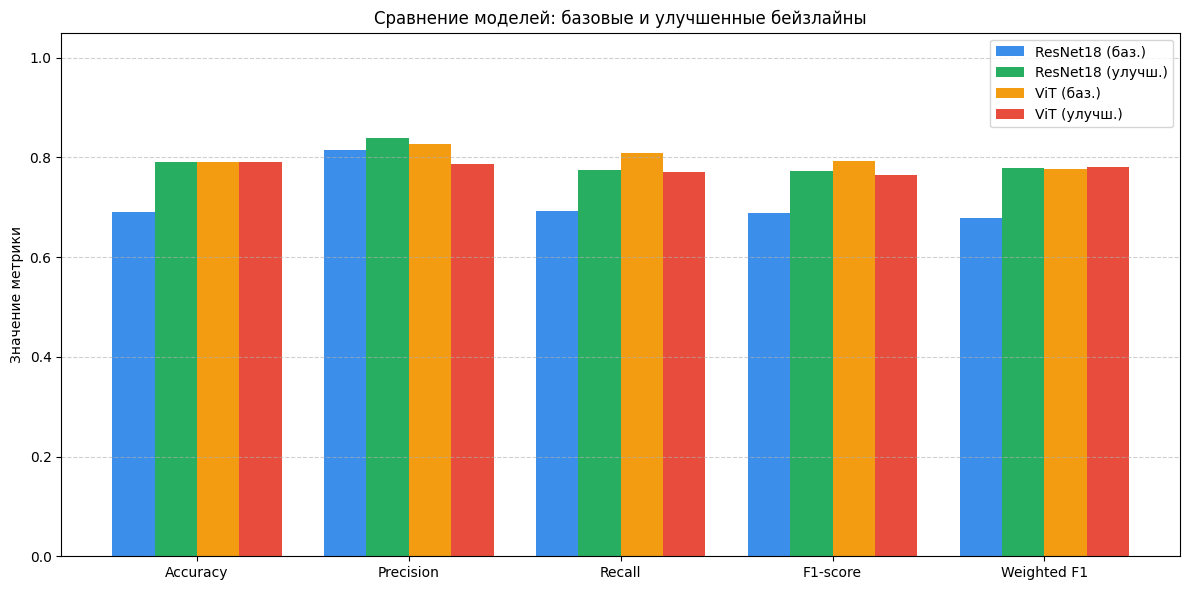

In [36]:
# Метрики для графика
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
resnet_old = [accuracy_resnet, precision_resnet, recall_resnet, f1_resnet, weighted_resnet]
resnet_new = [accuracy_best_resnet, precision_best_resnet, recall_best_resnet, f1_best_resnet, weighted_best_resnet]
vit_old = [accuracy_vit, precision_vit, recall_vit, f1_vit, weighted_vit]
vit_new = [accuracy_best_vit, precision_best_vit, recall_best_vit, f1_best_vit, weighted_best_vit]

x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * width, resnet_old, width, label="ResNet18 (баз.)", color="#3b8eea")
plt.bar(x - 0.5 * width, resnet_new, width, label="ResNet18 (улучш.)", color="#27ae60")
plt.bar(x + 0.5 * width, vit_old, width, label="ViT (баз.)", color="#f39c12")
plt.bar(x + 1.5 * width, vit_new, width, label="ViT (улучш.)", color="#e74c3c")

plt.ylabel("Значение метрики")
plt.title("Сравнение моделей: базовые и улучшенные бейзлайны")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### g. Выводы

Улучшения показали себя очень хорошо. Метрики улучшились

## 4. Имплементация алгоритма машинного обучения 

### a. Самостоятельная имплементация алгоритмов машинного обучения для классификации и регрессии

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out
    
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Преобразуем изображение в патчи с помощью свёрточного слоя
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # x: [B, N, embed_dim]
        attn_output, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + attn_output
        x = x + self.mlp(self.norm2(x))
        return x

Имплементация ResNet

In [38]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        # Начальный слой
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Последовательность блоков
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
def custom_resnet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


Имплементация ViT

In [39]:
class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=10,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super(ViT, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        # Классификационный токен
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Позиционные эмбеддинги
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Последовательность энкодер-блоков
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)  # [B, num_patches, embed_dim]
        
        # Добавляем классификационный токен
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)            # [B, 1+num_patches, embed_dim]
        
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        cls_output = x[:, 0]  # Используем выход токена [CLS]
        x = self.head(cls_output)
        return x

def custom_vit_b_16(num_classes=10, img_size=224):
    return ViT(img_size=img_size, patch_size=16, in_channels=3, num_classes=num_classes,
               embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.1)

### b. Обучение имплементированной модели

ResNet

In [40]:
custom_resnet_model = custom_resnet18(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_resnet_model.parameters(), lr=1e-4)

train_model(custom_resnet_model, criterion, optimizer, train_loader, test_loader)

Эпоха 1/3, Потери: 1.7266
Эпоха 2/3, Потери: 0.8340
Эпоха 3/3, Потери: 0.5336
Точность на тестовой выборке: 0.20


ViT

In [ ]:
custom_vit_model = custom_vit_b_16(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_vit_model.parameters(), lr=1e-4)

train_model(custom_vit_model, criterion, optimizer, train_loader, test_loader)

### c. Оценка качества имплементированных моделей

In [46]:
# ResNet
report_custom_resnet = evaluate_model(resnet_model, test_loader, class_names)

accuracy_custom_resnet = report_custom_resnet["accuracy"]
precision_custom_resnet = report_custom_resnet["macro avg"]["precision"]
recall_custom_resnet = report_custom_resnet["macro avg"]["recall"]
f1_custom_resnet = report_custom_resnet["macro avg"]["f1-score"]
weighted_custom_resnet = report_custom_resnet["weighted avg"]["f1-score"]

print(f"ResNet18 Accuracy: {accuracy_custom_resnet:.4f}")
print(f"Precision: {precision_custom_resnet:.4f}, Recall: {recall_custom_resnet:.4f}, F1: {f1_custom_resnet:.4f}")
print(f"MWeighted avg: {weighted_custom_resnet:.4f}")

# ViT
report_custom_vit = evaluate_model(vit_model, test_loader, class_names)

# Извлекаем нужные метрики
accuracy_custom_vit = report_custom_vit["accuracy"]
precision_custom_vit = report_custom_vit["macro avg"]["precision"]
recall_custom_vit = report_custom_vit["macro avg"]["recall"]
f1_custom_vit = report_custom_vit["macro avg"]["f1-score"]
weighted_custom_vit = report_custom_vit["weighted avg"]["f1-score"]

print(f"ViT Accuracy: {accuracy_custom_vit:.4f}")
print(f"Precision: {precision_custom_vit:.4f}, Recall: {recall_custom_vit:.4f}, F1: {f1_custom_vit:.4f}")
print(f"Weighted avg: {weighted_custom_vit:.4f}")


ResNet18 Accuracy: 0.3000
Precision: 0.1310, Recall: 0.2222, F1: 0.1407
MWeighted avg: 0.2089
ViT Accuracy: 0.5000
Precision: 0.2917, Recall: 0.4444, F1: 0.3286
Weighted avg: 0.4114


### d. Сравнение результатов первоначального бейзлайна и имплементированных моделей

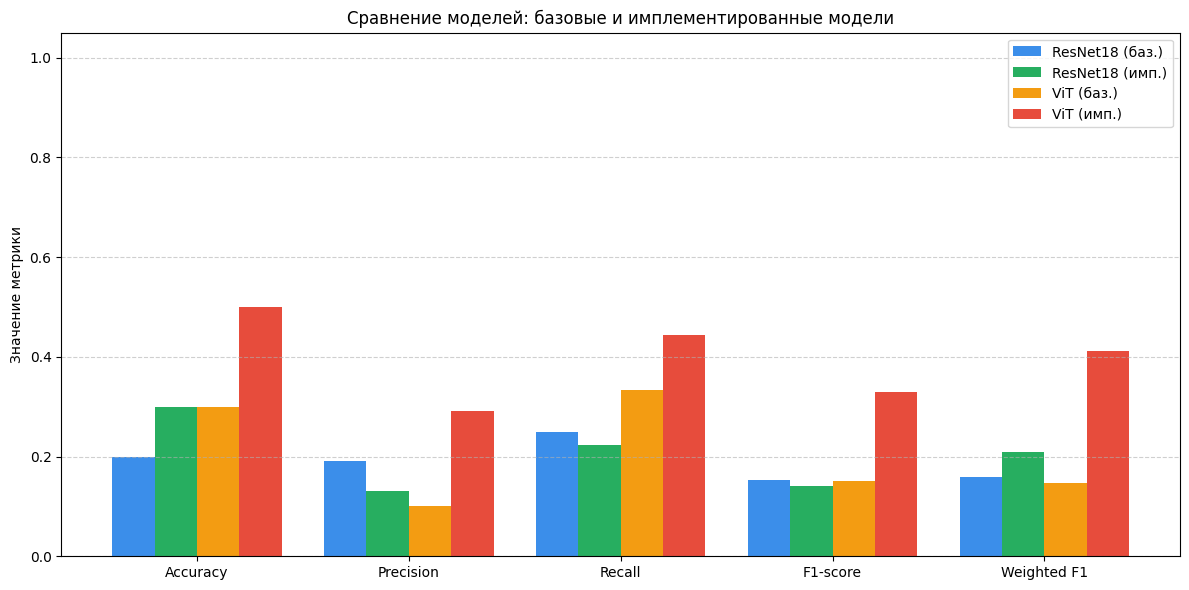

In [47]:
# Метрики для графика
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
resnet_old = [accuracy_resnet, precision_resnet, recall_resnet, f1_resnet, weighted_resnet]
resnet_new = [accuracy_custom_resnet, precision_custom_resnet, recall_custom_resnet, f1_custom_resnet, weighted_custom_resnet]
vit_old = [accuracy_vit, precision_vit, recall_vit, f1_vit, weighted_vit]
vit_new = [accuracy_custom_vit, precision_custom_vit, recall_custom_vit, f1_custom_vit, weighted_custom_vit]

x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * width, resnet_old, width, label="ResNet18 (баз.)", color="#3b8eea")
plt.bar(x - 0.5 * width, resnet_new, width, label="ResNet18 (имп.)", color="#27ae60")
plt.bar(x + 0.5 * width, vit_old, width, label="ViT (баз.)", color="#f39c12")
plt.bar(x + 1.5 * width, vit_new, width, label="ViT (имп.)", color="#e74c3c")

plt.ylabel("Значение метрики")
plt.title("Сравнение моделей: базовые и имплементированные модели")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### e. Выводы

Имплементированные модели в среднем показали себя лучше, чем базовые

### f. Добавление техник из улучшенного бейзлайна

### g. Обучение на улучшенном бейзлайне

ResNet

In [49]:
custom_resnet_model = custom_resnet18(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_resnet_model.parameters(), lr=1e-3)


train_model(resnet_model, criterion_res, optimizer_res, resnet_best_train_loader, test_best_loader, num_epochs=4)

Эпоха 1/4, Потери: 1.0178
Эпоха 2/4, Потери: 0.0862
Эпоха 3/4, Потери: 0.0551
Эпоха 4/4, Потери: 0.0941
Точность на тестовой выборке: 0.30


ViT

In [50]:
custom_vit_model = custom_vit_b_16(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_vit_model.parameters(), lr=1e-4)

train_model(vit_model, criterion_vit, optimizer_vit, vit_best_train_loader, test_best_loader, num_epochs=3)

Эпоха 1/3, Потери: 0.0221
Эпоха 2/3, Потери: 0.0109
Эпоха 3/3, Потери: 0.0078
Точность на тестовой выборке: 0.40


### h. Оценка качества моделей на улучшенном бейзлайне

In [51]:
# ResNet
report_custom_best_resnet = evaluate_model(resnet_model, test_loader, class_names)

accuracy_custom_best_resnet = report_custom_best_resnet["accuracy"]
precision_custom_best_resnet = report_custom_best_resnet["macro avg"]["precision"]
recall_custom_best_resnet = report_custom_best_resnet["macro avg"]["recall"]
f1_custom_best_resnet = report_custom_best_resnet["macro avg"]["f1-score"]
weighted_custom_best_resnet = report_custom_best_resnet["weighted avg"]["f1-score"]

# ViT
report_custom_best_vit = evaluate_model(vit_model, test_loader, class_names)

accuracy_custom_best_vit = report_custom_best_vit["accuracy"]
precision_custom_best_vit = report_custom_best_vit["macro avg"]["precision"]
recall_custom_best_vit = report_custom_best_vit["macro avg"]["recall"]
f1_custom_best_vit = report_custom_best_vit["macro avg"]["f1-score"]
weighted_custom_best_vit = report_custom_best_vit["weighted avg"]["f1-score"]

### i. Сравнение результатов первоначального бейзлайна с улучшенным

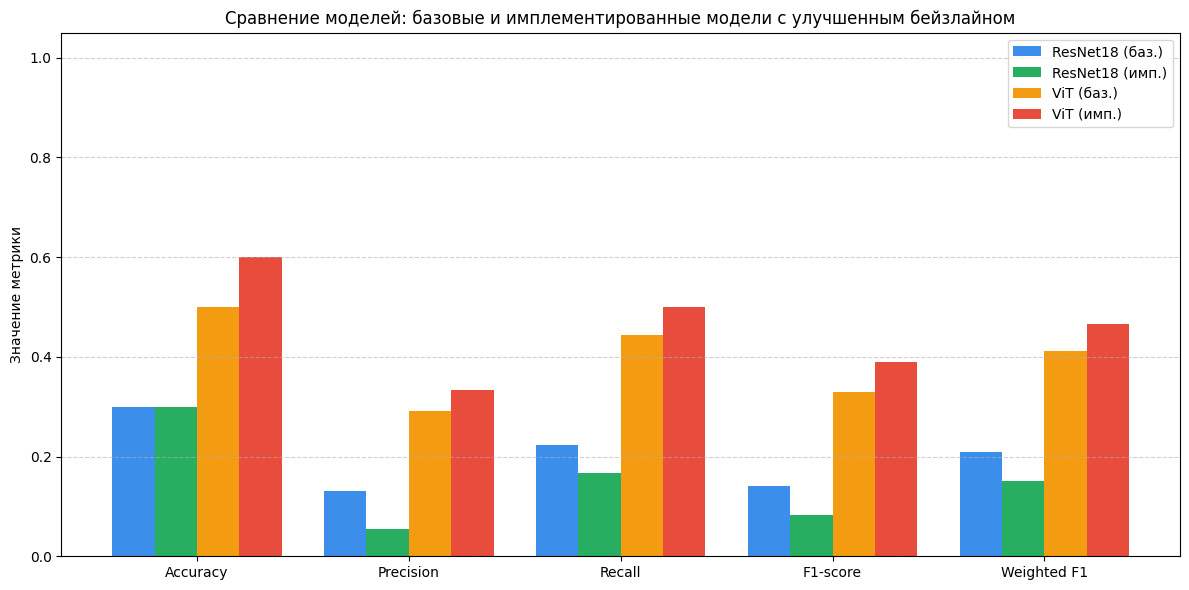

In [52]:
# Метрики для графика
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Weighted F1"]
resnet_old = [accuracy_best_resnet, precision_best_resnet, recall_best_resnet, f1_best_resnet, weighted_best_resnet]
resnet_new = [accuracy_custom_best_resnet, precision_custom_best_resnet, recall_custom_best_resnet, f1_custom_best_resnet, weighted_custom_best_resnet]
vit_old = [accuracy_best_vit, precision_best_vit, recall_best_vit, f1_best_vit, weighted_best_vit]
vit_new = [accuracy_custom_best_vit, precision_custom_best_vit, recall_custom_best_vit, f1_custom_best_vit, weighted_custom_best_vit]

x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * width, resnet_old, width, label="ResNet18 (баз.)", color="#3b8eea")
plt.bar(x - 0.5 * width, resnet_new, width, label="ResNet18 (имп.)", color="#27ae60")
plt.bar(x + 0.5 * width, vit_old, width, label="ViT (баз.)", color="#f39c12")
plt.bar(x + 1.5 * width, vit_new, width, label="ViT (имп.)", color="#e74c3c")

plt.ylabel("Значение метрики")
plt.title("Сравнение моделей: базовые и имплементированные модели с улучшенным бейзлайном")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### j. Выводы

С улучшенным безлайном имплементированная модель ResNet показала себя немного хуже обычной, однако с ViT всё наоборот - метрики имплементированной содели лучше